# Simulation Project

## Assumptions

There are a number of different assumptions for this project. It is assumed that the k signalling blocks are of constant length and a fixed train schedule of n trains per hour is used. Also, only 1 train is allowed to enter a block at a time. When a train enters a block the entry signal is red and this will switch back to green 5 seconds after the end of the train has left the block. There are also some details regarding the speed of the train which are given below. The impact of air resistance is ignored for this project.

- Max speed = $86.1 m/s$

- Acceleration = $0.76 m/s^{2}$

- Distance = 4878m

- Time = 113.3s

- Deacceleration = $0.38 m/s^{2}$


# Import the libraries

In [524]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np

import simpy

In [525]:
import seaborn as sns
import matplotlib.style as style
style.use("ggplot") #This style is just a personal prefernce
sns.set_context('paper') # Everything is set as if for a a paper
print("libraries imported!")

libraries imported!


# Prepare data

Will create a dataframe for this project with the data specified in the project brief. The number of signalling blocks can be varied by changing the number of signalling blocks k in the dataframe. The distance between each block should be equal and it is found by dividing the total distance by the number of signalling blocks. 

In [1800]:
k = 10 #Mumber of signalling blocks
d = int(145000/k) # distance divided by number of signalling blocks
print(d)

14500
186.0


In [1801]:
data = {"Number": [1,2,3,4,5,6,7,8,9,10], #This column is used for the simulation code later on.
        "Line": ["HS2","HS2","HS2","HS2","HS2","HS2","HS2","HS2","HS2","HS2"],
       "From":["London Old Oak","B1",'B2','B3','B4','B5','B6','B7','B8','B9'],
       "To": ["B1",'B2','B3','B4','B5','B6','B7','B8','B9',"Birmingham Interchange"],
       "Distance": [d,d,d,d,d,d,d,d,d,d]}

df  = pd.DataFrame(data, columns = ["Number","Line","From","To","Distance"])

In [1802]:
df

,Number,Line,From,To,Distance
0,1,HS2,London Old Oak,B1,14500
1,2,HS2,B1,B2,14500
2,3,HS2,B2,B3,14500
3,4,HS2,B3,B4,14500
4,5,HS2,B4,B5,14500
5,6,HS2,B5,B6,14500
6,7,HS2,B6,B7,14500
7,8,HS2,B7,B8,14500
8,9,HS2,B8,B9,14500
9,10,HS2,B9,Birmingham Interchange,14500


## Expected Drive Time
Now that the dataframe has been connected I will find the total drive time. I will use the timeTo 
function to travel a given distance based on acceleration, max velocity and distance. This drive time will be used later on in the simulation.

In [1803]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a         # time to accelerate to maxV
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/a)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*ta + (d-da)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

In [1804]:
df["Drive Time"] = int(timeTo(0.76,86.1,d))
df["max a"] = 0.76
df["max v"] = 86.1

In [1805]:
df['Dwell Time']=0 #Will introduce distribution to this column

In [1806]:
df

,Number,Line,From,To,Distance,Drive Time,max a,max v,Dwell Time
0,1,HS2,London Old Oak,B1,14500,281,0.76,86.1,0
1,2,HS2,B1,B2,14500,281,0.76,86.1,0
2,3,HS2,B2,B3,14500,281,0.76,86.1,0
3,4,HS2,B3,B4,14500,281,0.76,86.1,0
4,5,HS2,B4,B5,14500,281,0.76,86.1,0
5,6,HS2,B5,B6,14500,281,0.76,86.1,0
6,7,HS2,B6,B7,14500,281,0.76,86.1,0
7,8,HS2,B7,B8,14500,281,0.76,86.1,0
8,9,HS2,B8,B9,14500,281,0.76,86.1,0
9,10,HS2,B9,Birmingham Interchange,14500,281,0.76,86.1,0


Make a copy of the dataframe. This acts as a checkpoint.

In [1807]:
df1 = df.copy() 

# Variability in Drive Time

Will create a log-normal distribution and add values to the drive time in order to introduce variabilty caused by events such as weather. The mean and standard deviation are set as 3.0 and 1.0 respectively. 

In [1808]:
mu, sigma = 3., 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, k)

In [1809]:
df1["Dwell Time"] = df1["Dwell Time"] + s #Add on the log-normal distribution to the "dwell time"

In [1810]:
df1

,Number,Line,From,To,Distance,Drive Time,max a,max v,Dwell Time
0,1,HS2,London Old Oak,B1,14500,281,0.76,86.1,168.074748
1,2,HS2,B1,B2,14500,281,0.76,86.1,64.481812
2,3,HS2,B2,B3,14500,281,0.76,86.1,7.144120
3,4,HS2,B3,B4,14500,281,0.76,86.1,11.768837
4,5,HS2,B4,B5,14500,281,0.76,86.1,6.682296
5,6,HS2,B5,B6,14500,281,0.76,86.1,17.430849
6,7,HS2,B6,B7,14500,281,0.76,86.1,38.019550
7,8,HS2,B7,B8,14500,281,0.76,86.1,28.916429
8,9,HS2,B8,B9,14500,281,0.76,86.1,18.398682
9,10,HS2,B9,Birmingham Interchange,14500,281,0.76,86.1,76.264226


In [1811]:
print(df1["Dwell Time"].min())
print(df1["Dwell Time"].max())
print(df1["Dwell Time"].mean())

6.682295631166124
168.07474841041378
43.71815500825575


Text(0.5, 1.0, 'Distribution of Dwell Time using Log-Normal Distribution')

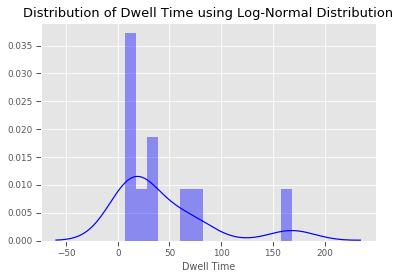

In [1860]:
#Visualise the distribution using a histogram
sns.distplot(df1["Dwell Time"], bins = 15, color="blue")
plt.title("Distribution of Dwell Time using Log-Normal Distribution",fontsize = 13)

# Modelling


Components of the system will be described by Python classes.

### Define time conversion method

In [1813]:
def daytime(t): 
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now) #Return the current time in the simulation

## Train() class

In [1814]:
class Train(object):
        def __init__(self, i, df1, maxP = 600):
            self.name = ' [Train '+f"{i:2d}"+']' #Get the name of the train
            self.df1 = df1 #use the data with the log-normal distribution.
            self.maxP = maxP
            self.p = 0
     

        def process(self):
            for number in self.df1['Number']:
                count = 0 #Initialize the count at 0
                data = self.df1[self.df1['Number'] == number]
                Start_Point = data['From'].tolist() #Where the train is leaving from
                End_Point = data['To'].tolist() #Where the train is going to
                Start_Point = Start_Point[0]
                End_Point = End_Point[0]
                #print(End_Location)
                for loc in data['From']:
                    data1=df1[df1['From'] == loc]
                    streamtime=data1.iloc[0].at['Drive Time'] #Include the drive time
                    dwelltime=data1.iloc[0].at['Dwell Time'] #Include the dwell time
                    yield env.timeout(dwelltime)
                    #Print where the train will leave and arrive. Then print when it has arrive
                    print(f"{now():s} {self.name:s} departed from {Start_Point:s} for {End_Point:s}")
                    yield env.timeout(streamtime)
                    print(f"{now():s} {self.name:s} arrived {End_Point:s}")

# Optimisation

Will create a new dataframe with different values of k, n and t and use these values in order to maximise the number of trains operating per hour under the constraint that the average delay time should not be higher than half the scheduled time between consecutive
trains.

In [1844]:
#Global DataFrame is created to store the information of moving trains
df_opt = pd.DataFrame(columns= ['TRAIN', 'TIME'])

The line function is perhaps the most important function for the entire simulation process. It allows the start and stop time of the simulation process to be changed. 

Also if the simulation starts at 7am the 24th train leaves just after 9am. So a 30 minute delay which is 1800 seconds is introduced to model a breakdown due to electrical failure as an example.

The train number and train time of each train are recorded and will be appended to the df_opt dataframe. That dataframe will be the one used for optimisation.

In [1855]:
def line(start=7*3600, stop=22*3600, timing=300):
        global df_opt #Starting at 7am and finishing at 8am
        yield env.timeout(start-env.now)
        for n in range(int((stop-start)/timing)): #n is the number of trains. 
            p = Train(n, df1)
            #Introduce delay in this loop 
            if n == 24: #This is the train just after 9am. 
                #Introduce a 30 minute delay so the above train does not run.
                yield env.timeout(1800) #30 mins = 1800 seconds 
            record = {"TRAIN":n , "TIME": (env.now)} #Save results of simulation
            df_opt = df_opt.append(record, ignore_index=True) #Append to dataframe
            env.process(p.process())
            yield env.timeout(timing) #Finish simulation

In [1856]:
env = simpy.Environment()   
env.process(line())
env.run()

07:02:48  [Train  0] departed from London Old Oak for B1
07:07:29  [Train  0] arrived B1
07:07:48  [Train  1] departed from London Old Oak for B1
07:08:33  [Train  0] departed from B1 for B2
07:12:29  [Train  1] arrived B1
07:12:48  [Train  2] departed from London Old Oak for B1
07:13:14  [Train  0] arrived B2
07:13:21  [Train  0] departed from B2 for B3
07:13:33  [Train  1] departed from B1 for B2
07:17:29  [Train  2] arrived B1
07:17:48  [Train  3] departed from London Old Oak for B1
07:18:02  [Train  0] arrived B3
07:18:14  [Train  0] departed from B3 for B4
07:18:14  [Train  1] arrived B2
07:18:21  [Train  1] departed from B2 for B3
07:18:33  [Train  2] departed from B1 for B2
07:22:29  [Train  3] arrived B1
07:22:48  [Train  4] departed from London Old Oak for B1
07:22:55  [Train  0] arrived B4
07:23:02  [Train  0] departed from B4 for B5
07:23:02  [Train  1] arrived B3
07:23:14  [Train  1] departed from B3 for B4
07:23:14  [Train  2] arrived B2
07:23:21  [Train  2] departed from 

08:38:02  [Train 15] departed from B4 for B5
08:38:02  [Train 16] arrived B3
08:38:09  [Train 10] arrived B9
08:38:10  [Train 11] arrived B8
08:38:14  [Train 16] departed from B3 for B4
08:38:14  [Train 17] arrived B2
08:38:19  [Train 13] departed from B6 for B7
08:38:21  [Train 17] departed from B2 for B3
08:38:28  [Train 11] departed from B8 for B9
08:38:29  [Train 12] departed from B7 for B8
08:38:33  [Train 18] departed from B1 for B2
08:39:07  [Train  9] arrived Birmingham Interchange
08:39:26  [Train 10] departed from B9 for Birmingham Interchange
08:42:29  [Train 19] arrived B1
08:42:41  [Train 14] arrived B6
08:42:43  [Train 15] arrived B5
08:42:48  [Train 20] departed from London Old Oak for B1
08:42:55  [Train 16] arrived B4
08:43:00  [Train 15] departed from B5 for B6
08:43:00  [Train 13] arrived B7
08:43:02  [Train 16] departed from B4 for B5
08:43:02  [Train 17] arrived B3
08:43:09  [Train 11] arrived B9
08:43:10  [Train 12] arrived B8
08:43:14  [Train 17] departed from B3

10:12:41  [Train 26] arrived B6
10:12:43  [Train 27] arrived B5
10:12:48  [Train 32] departed from London Old Oak for B1
10:12:55  [Train 28] arrived B4
10:13:00  [Train 27] departed from B5 for B6
10:13:00  [Train 25] arrived B7
10:13:02  [Train 28] departed from B4 for B5
10:13:02  [Train 29] arrived B3
10:13:10  [Train 24] arrived B8
10:13:14  [Train 29] departed from B3 for B4
10:13:14  [Train 30] arrived B2
10:13:19  [Train 26] departed from B6 for B7
10:13:21  [Train 30] departed from B2 for B3
10:13:28  [Train 24] departed from B8 for B9
10:13:29  [Train 25] departed from B7 for B8
10:13:33  [Train 31] departed from B1 for B2
10:17:29  [Train 32] arrived B1
10:17:41  [Train 27] arrived B6
10:17:43  [Train 28] arrived B5
10:17:48  [Train 33] departed from London Old Oak for B1
10:17:55  [Train 29] arrived B4
10:18:00  [Train 28] departed from B5 for B6
10:18:00  [Train 26] arrived B7
10:18:02  [Train 29] departed from B4 for B5
10:18:02  [Train 30] arrived B3
10:18:09  [Train 24]

11:18:09  [Train 36] arrived B9
11:18:10  [Train 37] arrived B8
11:18:14  [Train 42] departed from B3 for B4
11:18:14  [Train 43] arrived B2
11:18:19  [Train 39] departed from B6 for B7
11:18:21  [Train 43] departed from B2 for B3
11:18:28  [Train 37] departed from B8 for B9
11:18:29  [Train 38] departed from B7 for B8
11:18:33  [Train 44] departed from B1 for B2
11:19:07  [Train 35] arrived Birmingham Interchange
11:19:26  [Train 36] departed from B9 for Birmingham Interchange
11:22:29  [Train 45] arrived B1
11:22:41  [Train 40] arrived B6
11:22:43  [Train 41] arrived B5
11:22:48  [Train 46] departed from London Old Oak for B1
11:22:55  [Train 42] arrived B4
11:23:00  [Train 41] departed from B5 for B6
11:23:00  [Train 39] arrived B7
11:23:02  [Train 42] departed from B4 for B5
11:23:02  [Train 43] arrived B3
11:23:09  [Train 37] arrived B9
11:23:10  [Train 38] arrived B8
11:23:14  [Train 43] departed from B3 for B4
11:23:14  [Train 44] arrived B2
11:23:19  [Train 40] departed from B6

12:27:48  [Train 59] departed from London Old Oak for B1
12:27:55  [Train 55] arrived B4
12:28:00  [Train 54] departed from B5 for B6
12:28:00  [Train 52] arrived B7
12:28:02  [Train 55] departed from B4 for B5
12:28:02  [Train 56] arrived B3
12:28:09  [Train 50] arrived B9
12:28:10  [Train 51] arrived B8
12:28:14  [Train 56] departed from B3 for B4
12:28:14  [Train 57] arrived B2
12:28:19  [Train 53] departed from B6 for B7
12:28:21  [Train 57] departed from B2 for B3
12:28:28  [Train 51] departed from B8 for B9
12:28:29  [Train 52] departed from B7 for B8
12:28:33  [Train 58] departed from B1 for B2
12:29:07  [Train 49] arrived Birmingham Interchange
12:29:26  [Train 50] departed from B9 for Birmingham Interchange
12:32:29  [Train 59] arrived B1
12:32:41  [Train 54] arrived B6
12:32:43  [Train 55] arrived B5
12:32:48  [Train 60] departed from London Old Oak for B1
12:32:55  [Train 56] arrived B4
12:33:00  [Train 55] departed from B5 for B6
12:33:00  [Train 53] arrived B7
12:33:02  [T

13:18:14  [Train 66] departed from B3 for B4
13:18:14  [Train 67] arrived B2
13:18:19  [Train 63] departed from B6 for B7
13:18:21  [Train 67] departed from B2 for B3
13:18:28  [Train 61] departed from B8 for B9
13:18:29  [Train 62] departed from B7 for B8
13:18:33  [Train 68] departed from B1 for B2
13:19:07  [Train 59] arrived Birmingham Interchange
13:19:26  [Train 60] departed from B9 for Birmingham Interchange
13:22:29  [Train 69] arrived B1
13:22:41  [Train 64] arrived B6
13:22:43  [Train 65] arrived B5
13:22:48  [Train 70] departed from London Old Oak for B1
13:22:55  [Train 66] arrived B4
13:23:00  [Train 65] departed from B5 for B6
13:23:00  [Train 63] arrived B7
13:23:02  [Train 66] departed from B4 for B5
13:23:02  [Train 67] arrived B3
13:23:09  [Train 61] arrived B9
13:23:10  [Train 62] arrived B8
13:23:14  [Train 67] departed from B3 for B4
13:23:14  [Train 68] arrived B2
13:23:19  [Train 64] departed from B6 for B7
13:23:21  [Train 68] departed from B2 for B3
13:23:28  [

14:13:02  [Train 76] departed from B4 for B5
14:13:02  [Train 77] arrived B3
14:13:09  [Train 71] arrived B9
14:13:10  [Train 72] arrived B8
14:13:14  [Train 77] departed from B3 for B4
14:13:14  [Train 78] arrived B2
14:13:19  [Train 74] departed from B6 for B7
14:13:21  [Train 78] departed from B2 for B3
14:13:28  [Train 72] departed from B8 for B9
14:13:29  [Train 73] departed from B7 for B8
14:13:33  [Train 79] departed from B1 for B2
14:14:07  [Train 70] arrived Birmingham Interchange
14:14:26  [Train 71] departed from B9 for Birmingham Interchange
14:17:29  [Train 80] arrived B1
14:17:41  [Train 75] arrived B6
14:17:43  [Train 76] arrived B5
14:17:48  [Train 81] departed from London Old Oak for B1
14:17:55  [Train 77] arrived B4
14:18:00  [Train 76] departed from B5 for B6
14:18:00  [Train 74] arrived B7
14:18:02  [Train 77] departed from B4 for B5
14:18:02  [Train 78] arrived B3
14:18:09  [Train 72] arrived B9
14:18:10  [Train 73] arrived B8
14:18:14  [Train 78] departed from B3

15:03:10  [Train 82] arrived B8
15:03:14  [Train 87] departed from B3 for B4
15:03:14  [Train 88] arrived B2
15:03:19  [Train 84] departed from B6 for B7
15:03:21  [Train 88] departed from B2 for B3
15:03:28  [Train 82] departed from B8 for B9
15:03:29  [Train 83] departed from B7 for B8
15:03:33  [Train 89] departed from B1 for B2
15:04:07  [Train 80] arrived Birmingham Interchange
15:04:26  [Train 81] departed from B9 for Birmingham Interchange
15:07:29  [Train 90] arrived B1
15:07:41  [Train 85] arrived B6
15:07:43  [Train 86] arrived B5
15:07:48  [Train 91] departed from London Old Oak for B1
15:07:55  [Train 87] arrived B4
15:08:00  [Train 86] departed from B5 for B6
15:08:00  [Train 84] arrived B7
15:08:02  [Train 87] departed from B4 for B5
15:08:02  [Train 88] arrived B3
15:08:09  [Train 82] arrived B9
15:08:10  [Train 83] arrived B8
15:08:14  [Train 88] departed from B3 for B4
15:08:14  [Train 89] arrived B2
15:08:19  [Train 85] departed from B6 for B7
15:08:21  [Train 89] dep

15:58:19  [Train 95] departed from B6 for B7
15:58:21  [Train 99] departed from B2 for B3
15:58:28  [Train 93] departed from B8 for B9
15:58:29  [Train 94] departed from B7 for B8
15:58:33  [Train 100] departed from B1 for B2
15:59:07  [Train 91] arrived Birmingham Interchange
15:59:26  [Train 92] departed from B9 for Birmingham Interchange
16:02:29  [Train 101] arrived B1
16:02:41  [Train 96] arrived B6
16:02:43  [Train 97] arrived B5
16:02:48  [Train 102] departed from London Old Oak for B1
16:02:55  [Train 98] arrived B4
16:03:00  [Train 97] departed from B5 for B6
16:03:00  [Train 95] arrived B7
16:03:02  [Train 98] departed from B4 for B5
16:03:02  [Train 99] arrived B3
16:03:09  [Train 93] arrived B9
16:03:10  [Train 94] arrived B8
16:03:14  [Train 99] departed from B3 for B4
16:03:14  [Train 100] arrived B2
16:03:19  [Train 96] departed from B6 for B7
16:03:21  [Train 100] departed from B2 for B3
16:03:28  [Train 94] departed from B8 for B9
16:03:29  [Train 95] departed from B7 

16:53:19  [Train 106] departed from B6 for B7
16:53:21  [Train 110] departed from B2 for B3
16:53:28  [Train 104] departed from B8 for B9
16:53:29  [Train 105] departed from B7 for B8
16:53:33  [Train 111] departed from B1 for B2
16:54:07  [Train 102] arrived Birmingham Interchange
16:54:26  [Train 103] departed from B9 for Birmingham Interchange
16:57:29  [Train 112] arrived B1
16:57:41  [Train 107] arrived B6
16:57:43  [Train 108] arrived B5
16:57:48  [Train 113] departed from London Old Oak for B1
16:57:55  [Train 109] arrived B4
16:58:00  [Train 108] departed from B5 for B6
16:58:00  [Train 106] arrived B7
16:58:02  [Train 109] departed from B4 for B5
16:58:02  [Train 110] arrived B3
16:58:09  [Train 104] arrived B9
16:58:10  [Train 105] arrived B8
16:58:14  [Train 110] departed from B3 for B4
16:58:14  [Train 111] arrived B2
16:58:19  [Train 107] departed from B6 for B7
16:58:21  [Train 111] departed from B2 for B3
16:58:28  [Train 105] departed from B8 for B9
16:58:29  [Train 106

17:43:14  [Train 119] departed from B3 for B4
17:43:14  [Train 120] arrived B2
17:43:19  [Train 116] departed from B6 for B7
17:43:21  [Train 120] departed from B2 for B3
17:43:28  [Train 114] departed from B8 for B9
17:43:29  [Train 115] departed from B7 for B8
17:43:33  [Train 121] departed from B1 for B2
17:44:07  [Train 112] arrived Birmingham Interchange
17:44:26  [Train 113] departed from B9 for Birmingham Interchange
17:47:29  [Train 122] arrived B1
17:47:41  [Train 117] arrived B6
17:47:43  [Train 118] arrived B5
17:47:48  [Train 123] departed from London Old Oak for B1
17:47:55  [Train 119] arrived B4
17:48:00  [Train 118] departed from B5 for B6
17:48:00  [Train 116] arrived B7
17:48:02  [Train 119] departed from B4 for B5
17:48:02  [Train 120] arrived B3
17:48:09  [Train 114] arrived B9
17:48:10  [Train 115] arrived B8
17:48:14  [Train 120] departed from B3 for B4
17:48:14  [Train 121] arrived B2
17:48:19  [Train 117] departed from B6 for B7
17:48:21  [Train 121] departed fr

18:58:00  [Train 132] departed from B5 for B6
18:58:00  [Train 130] arrived B7
18:58:02  [Train 133] departed from B4 for B5
18:58:02  [Train 134] arrived B3
18:58:09  [Train 128] arrived B9
18:58:10  [Train 129] arrived B8
18:58:14  [Train 134] departed from B3 for B4
18:58:14  [Train 135] arrived B2
18:58:19  [Train 131] departed from B6 for B7
18:58:21  [Train 135] departed from B2 for B3
18:58:28  [Train 129] departed from B8 for B9
18:58:29  [Train 130] departed from B7 for B8
18:58:33  [Train 136] departed from B1 for B2
18:59:07  [Train 127] arrived Birmingham Interchange
18:59:26  [Train 128] departed from B9 for Birmingham Interchange
19:02:29  [Train 137] arrived B1
19:02:41  [Train 132] arrived B6
19:02:43  [Train 133] arrived B5
19:02:48  [Train 138] departed from London Old Oak for B1
19:02:55  [Train 134] arrived B4
19:03:00  [Train 133] departed from B5 for B6
19:03:00  [Train 131] arrived B7
19:03:02  [Train 134] departed from B4 for B5
19:03:02  [Train 135] arrived B3


19:48:00  [Train 142] departed from B5 for B6
19:48:00  [Train 140] arrived B7
19:48:02  [Train 143] departed from B4 for B5
19:48:02  [Train 144] arrived B3
19:48:09  [Train 138] arrived B9
19:48:10  [Train 139] arrived B8
19:48:14  [Train 144] departed from B3 for B4
19:48:14  [Train 145] arrived B2
19:48:19  [Train 141] departed from B6 for B7
19:48:21  [Train 145] departed from B2 for B3
19:48:28  [Train 139] departed from B8 for B9
19:48:29  [Train 140] departed from B7 for B8
19:48:33  [Train 146] departed from B1 for B2
19:49:07  [Train 137] arrived Birmingham Interchange
19:49:26  [Train 138] departed from B9 for Birmingham Interchange
19:52:29  [Train 147] arrived B1
19:52:41  [Train 142] arrived B6
19:52:43  [Train 143] arrived B5
19:52:48  [Train 148] departed from London Old Oak for B1
19:52:55  [Train 144] arrived B4
19:53:00  [Train 143] departed from B5 for B6
19:53:00  [Train 141] arrived B7
19:53:02  [Train 144] departed from B4 for B5
19:53:02  [Train 145] arrived B3


20:47:29  [Train 158] arrived B1
20:47:41  [Train 153] arrived B6
20:47:43  [Train 154] arrived B5
20:47:48  [Train 159] departed from London Old Oak for B1
20:47:55  [Train 155] arrived B4
20:48:00  [Train 154] departed from B5 for B6
20:48:00  [Train 152] arrived B7
20:48:02  [Train 155] departed from B4 for B5
20:48:02  [Train 156] arrived B3
20:48:09  [Train 150] arrived B9
20:48:10  [Train 151] arrived B8
20:48:14  [Train 156] departed from B3 for B4
20:48:14  [Train 157] arrived B2
20:48:19  [Train 153] departed from B6 for B7
20:48:21  [Train 157] departed from B2 for B3
20:48:28  [Train 151] departed from B8 for B9
20:48:29  [Train 152] departed from B7 for B8
20:48:33  [Train 158] departed from B1 for B2
20:49:07  [Train 149] arrived Birmingham Interchange
20:49:26  [Train 150] departed from B9 for Birmingham Interchange
20:52:29  [Train 159] arrived B1
20:52:41  [Train 154] arrived B6
20:52:43  [Train 155] arrived B5
20:52:48  [Train 160] departed from London Old Oak for B1
2

21:38:00  [Train 164] departed from B5 for B6
21:38:00  [Train 162] arrived B7
21:38:02  [Train 165] departed from B4 for B5
21:38:02  [Train 166] arrived B3
21:38:09  [Train 160] arrived B9
21:38:10  [Train 161] arrived B8
21:38:14  [Train 166] departed from B3 for B4
21:38:14  [Train 167] arrived B2
21:38:19  [Train 163] departed from B6 for B7
21:38:21  [Train 167] departed from B2 for B3
21:38:28  [Train 161] departed from B8 for B9
21:38:29  [Train 162] departed from B7 for B8
21:38:33  [Train 168] departed from B1 for B2
21:39:07  [Train 159] arrived Birmingham Interchange
21:39:26  [Train 160] departed from B9 for Birmingham Interchange
21:42:29  [Train 169] arrived B1
21:42:41  [Train 164] arrived B6
21:42:43  [Train 165] arrived B5
21:42:48  [Train 170] departed from London Old Oak for B1
21:42:55  [Train 166] arrived B4
21:43:00  [Train 165] departed from B5 for B6
21:43:00  [Train 163] arrived B7
21:43:02  [Train 166] departed from B4 for B5
21:43:02  [Train 167] arrived B3


22:43:00  [Train 177] departed from B5 for B6
22:43:00  [Train 175] arrived B7
22:43:02  [Train 178] departed from B4 for B5
22:43:02  [Train 179] arrived B3
22:43:09  [Train 173] arrived B9
22:43:10  [Train 174] arrived B8
22:43:14  [Train 179] departed from B3 for B4
22:43:19  [Train 176] departed from B6 for B7
22:43:28  [Train 174] departed from B8 for B9
22:43:29  [Train 175] departed from B7 for B8
22:44:07  [Train 172] arrived Birmingham Interchange
22:44:26  [Train 173] departed from B9 for Birmingham Interchange
22:47:41  [Train 177] arrived B6
22:47:43  [Train 178] arrived B5
22:47:55  [Train 179] arrived B4
22:48:00  [Train 178] departed from B5 for B6
22:48:00  [Train 176] arrived B7
22:48:02  [Train 179] departed from B4 for B5
22:48:09  [Train 174] arrived B9
22:48:10  [Train 175] arrived B8
22:48:19  [Train 177] departed from B6 for B7
22:48:28  [Train 175] departed from B8 for B9
22:48:29  [Train 176] departed from B7 for B8
22:49:07  [Train 173] arrived Birmingham Inte

In [1857]:
df_opt 

,TRAIN,TIME
0,0,2520
1,1,2550
2,2,2580
3,3,2610
4,4,2640
...,...,...
355,175,79500
356,176,79800
357,177,80100
358,178,80400


The time variable does not take into account the different signalling blocks. Therefore, will divide by 10 as this was the number of signalling blocks specified at the start of the code. 

In [1848]:
df_opt["TIME"] = df_opt["TIME"]/k

Text(0.5, 0, 'Travel Times (s)')

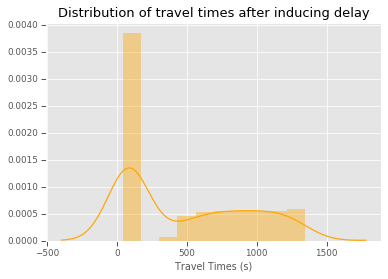

In [1861]:
sns.distplot(df_opt["TIME"]/60,hist=True,bins=10,color="orange")
plt.title("Distribution of travel times after inducing delay",fontsize=13)
plt.xlabel("Travel Times (s)")

In [1751]:
df_opt["TIME"].mean()

2445.4545454545455

## Multiple Linear Regression

Now that a dataframe has been obtained from the simulation the optimisation function will be found in order to determine the optimal number of n and k. 

In [1555]:
df_opt1 = df_opt.to_numpy() #Need to change the dataframe to a numpy array so it can be used in sklearn

In [35]:
from sklearn.linear_model import LinearRegression
Y = df_opt1[:,1] # Travel times
X = df_opt1[:,0] #Train no.


Y = Y.reshape(-1,1)
X = X.reshape(-1,1)
model = LinearRegression().fit(X,Y)
print(model.coef_)
print(model.intercept_)

[[30.]]
[2520.]


# Optimisation

Aim is to maximise the number of trains leaving per hour under the constraint that the average delay time should not be higher than half the scheduled time between consecutive trains. 

One thing that could be carried out is to collect the results of the simulation along with the train times in a csv file or dataframe and optimise the number of blocks and trains from that.

In [1862]:
opt_new = pd.read_csv("opt_data.csv")
opt_new.head()
print(len(opt_new))

66


In [1863]:
opt_new1 = opt_new.to_numpy()
opt_new1[:,[0,2]]

array([[1.500000e+01, 1.793330e+03],
       [1.400000e+01, 1.921430e+03],
       [1.300000e+01, 2.069230e+03],
       [1.200000e+01, 2.241670e+03],
       [1.100000e+01, 2.445450e+03],
       [1.000000e+01, 2.690000e+03],
       [9.000000e+00, 2.988890e+03],
       [8.000000e+00, 3.362500e+03],
       [7.000000e+00, 3.842860e+03],
       [6.000000e+00, 4.483330e+03],
       [5.000000e+00, 5.380000e+03],
       [1.500000e+01, 1.788330e+03],
       [1.400000e+01, 1.916070e+03],
       [1.300000e+01, 2.063070e+03],
       [1.200000e+01, 2.235420e+03],
       [1.100000e+01, 2.438640e+03],
       [1.000000e+01, 2.682500e+03],
       [9.000000e+00, 2.980550e+03],
       [8.000000e+00, 3.353125e+03],
       [7.000000e+00, 3.832140e+03],
       [6.000000e+00, 4.470830e+03],
       [5.000000e+00, 5.365000e+03],
       [1.500000e+01, 1.790000e+03],
       [1.400000e+01, 1.917860e+03],
       [1.300000e+01, 2.065380e+03],
       [1.200000e+01, 2.237500e+03],
       [1.100000e+01, 2.440910e+03],
 

In [1864]:
opt_new1[:,[1]]

array([[17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [17.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [11.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 9.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 8.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.],
       [ 7.]])

In [1770]:
from sklearn.linear_model import LinearRegression
Y = opt_new1[:,[1]] # Number of trains. This is what we want to maximise
X = opt_new1[:,[0,2]] #NO. of blocks and avg. travel time


#Y = Y.reshape(-1,1)
#X = X.reshape(-1,1)
model = LinearRegression().fit(X,Y)
print(model.coef_)
print(model.intercept_)

[[0.04700205 0.00014285]]
[9.93224414]


Now that the function is obtained I will try and maximise it using linear programming and the simplex method.

In [1779]:
import scipy.optimize as opt
from scipy.optimize import minimize

maximize .932 + 0.05x1 + 0.0001x2

subject to 2x1 + x2 ≤ 20

x1 + 2x3 ≤ 15

x1, x2 ≥ 0

In [1796]:
c = [-0.04700205,-0.00014285,]
b = [20,15]
A = [[2,1],[1,2]]
x1_bounds = (0, 20)
x2_bounds = (0, 15)

In [1797]:
res = opt.linprog(c,A,b, bounds = (x1_bounds,x2_bounds),method="simplex")

In [1798]:
res

     con: array([], dtype=float64)
     fun: -0.47002049999999995
 message: 'Optimization terminated successfully.'
     nit: 5
   slack: array([0., 5.])
  status: 0
 success: True
       x: array([10.,  0.])

In [1795]:
x0 = res.x[0]
x1 = res.x[1]
(x0, x1)

(10.0, 0.0)

# Conclusion

Therefore, 10 signalling blocks should be used to maximize the number of trains operating per hour.

f(x,y) = 9.932 + 0.047(10)+ ).00014286(0) = 10.502 ~ 11 trains

11 trains and 10 signalling blocks will give an average run time of 3105 seconds (51.75 minutes).

There should be methods that would lead to a lower travelling time but this method has managed to maximise the number of trains operating per hour.